## Emily's state transition function

In [133]:
import Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [134]:
import Pkg
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [135]:
using CSV, Random, DataFrames
using GLMakie
using GeoDatasets

In [136]:
include("../dev-yuji/heuristics.jl")
include("../dev-emily/state.jl")

TR_orbit (generic function with 2 methods)

In [137]:
dataset = "../src/obs_site_Earth.csv"

"../src/obs_site_Earth.csv"

In [138]:
# constants
Re = 6371;
mu_E = 3.986004418e5; #km^3/m^2  
slew_limit = 15

15

## MCTS Functions

In [139]:
# A shortened representation of MDP that works for online planning (no full state-space, TR captures T and R)
struct MDP 
    gamma # Discount factor
    A # Action space
    TR # Transition model
end 

In [140]:
function rollout(P, s, d)
    s_ = copy(s)
    ret = 0.0 
    for t in 1:d
        a = rand(A)
        s_, r = P.TR(s_, a)
        ret += P.gamma^(t-1) * r
    end 
    return ret 
end

struct MonteCarloTreeSearch
    P
    N   # visit count
    Q   # action-value estimate
    d   # depth to go through for the Monte Carlo search
    d_r # depth to go through the rollout at the end of the MCTS
    m   # num of simulations
    c   # exploration constant 
    U   # value function estimate 
end 

function (π::MonteCarloTreeSearch)(s)
    for k in 1:π.m
        simulate!(π,s)
    end 
    return argmax(a->π.Q[(s,a)], π.P.A)
end 

function simulate!(π::MonteCarloTreeSearch, s, d=π.d)
    if d <= 0 
        return rollout(π.P, s, π.d_r)
    end 
    P, N, Q, c = π.P, π.N, π.Q, π.c
    A, TR, gamma = P.A, P.TR, P.gamma
    if !haskey(N,(s,first(A)))  # if (s,a) has never been visited
        for a in A
            N[(s,a)] = 0 
            Q[(s,a)] = 0
        end 
        return rollout(π.P, s, π.d_r)   
    end
    
    # if (s,a) has been visited
    a = explore(π,s)
    # println("State before TR in simulate \n", s)
    s_, r = TR(s,a)
    # println("State after TR in simulate \n", s)
    q = r + gamma* simulate!(π, s_, d-1) 
    N[(s,a)] += 1  # +1 for visit count 
    Q[(s,a)] += (q-Q[(s,a)]) / N[(s,a)]  # The more you visited, the update of the Q will (usually) converge 
    return q 
end 

bonus(Nsa, Ns) = Nsa==0 ? Inf : sqrt(log(Ns)/Nsa)

function explore(π::MonteCarloTreeSearch, s)
    A, N, Q, c = π.P.A, π.N, π.Q, π.c
    Ns = sum(N[(s,a)] for a in A)
    # objective = Q+bonus term 
    # if there is no past visit, then that exploration is always prioritized 
    return argmax(a -> Q[(s,a)] + c*bonus(N[(s,a)], Ns), A)  
end 

function feasible_actions(s, A)
    # s: Current state
    # A: Total action space
    new_action_space = [1] # initialize with do nothing
    for action in A
        if action > 1
            rv = koe2cart(copy(s.koe), mu_E)
            target = s.target_list[action-1]
            target_pos = ECEF_to_ECI([target[1], target[2], target[3], 0, 0, 0], s.dt)
            R_eci2rtn = ECI_to_RTN_matrix(rv)
            look_vec_rtn = R_eci2rtn * (target_pos[1:3] .- rv[1:3]) 
            
            horizon_dist = sqrt(norm(rv[1:3])^2 - Re^2)
            far_side = norm(look_vec_rtn) > horizon_dist
            if far_side
            else
                push!(new_action_space, action)
            end
        end
    end
    return new_action_space
end


feasible_actions (generic function with 1 method)

## Run the problem with Heuristic actions

In [172]:

# Create an intial state
# x0 = 0 # checl: are the test points centered around x=0?
# y0 = 0
# dydt = 1
# alt = 50
koe0 = [
    7057.0,  # a [km]
    0.000879,  # e
    deg2rad(98.12),  # i
    deg2rad(255.09),  # Ω [rad]
    deg2rad(225.37),  # ω [rad]
    deg2rad(75.0),  # M [rad]
]
att = [0.,0.]
dt = 0
target_list, n_targets = create_target_list_3d(dataset)
observed_list = zeros(n_targets)
state = State3d(koe0, att, dt, target_list, observed_list)

# state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))
# state = State3d(koe, att, dt, target_list, zeros(n_targets))
# print(state)
# create action list
""" 
Action space:
1 -> Do nothing OR: rotate to neutral/some intermediate position
2 -> Image target 1
.
.
.
n+1 -> Image target n 
"""
A = 1:n_targets+1 
reward_total = 0
state_list = []
action_list = []
time_step = 30 # seconds
num_minutes = 30
slew_limit = 15
for t in 0:time_step:2000
    global state
    state_copy = copy(state)
    push!(state_list, state_copy)
    action = heuristic_action(state, slew_limit)
    push!(action_list, action)
    state, reward = TR_orbit(state, action, time_step)
    reward_total += reward


    # Calculate progress percentage
    progress = t / 2000 * 100

    # Create a string representation of the progress bar
    bar_length = 20
    bar_progress = round(Int, progress / (100 / bar_length))
    bar_string = "[" * repeat("=" , bar_progress) * repeat(" " , bar_length - bar_progress) * "]"

    # Print the progress bar
    print("\rProgress: $bar_string $(round(progress, digits=2))%")

    # Sleep for a short duration to see the progress bar
    sleep(0.1)
end
println("Final reward: ", reward_total)

Progress: [====================] 99.0%Final reward: 13.529898137306649


In [173]:
df = CSV.read(dataset, DataFrame)
target_lambda = df.lambda
target_phi = df.phi
target_mean_reward = df.r_mean
observed_target_lambda = []
observed_target_phi = []
observed_target_reward = []
total_observed = 0
for i in 1:length(state.observed_list)
    if state.observed_list[i] == 1
        push!(observed_target_lambda, target_lambda[i])
        push!(observed_target_phi, target_phi[i])
        push!(observed_target_reward, target_mean_reward[i])
        total_observed += 1
    end
end
observed_target_lambda = Float64.(observed_target_lambda)
observed_target_phi = Float64.(observed_target_phi)
observed_target_reward = Float64.(observed_target_reward)

angs_list = []
for i in 1:length(action_list)
    # println(i)
    action = action_list[i]
    # println(action)
    state = state_list[i]
    # println(state)
    if action > 1
        target = state.target_list[action-1]
        push!(angs_list, get_slew_angle(state.koe, target, state.dt))
    else 
        if i > 1
            push!(angs_list, angs_list[i-1])
        else
            push!(angs_list, (0,0))
        end
    end
end
angs_list = collect(angs_list)
cross_ang_des = [t[1] for t in angs_list];
along_ang_des = [t[2] for t in angs_list];

In [174]:
println("reward_total: ", reward_total)
println("total observed states: ",  total_observed)

reward_total: 13.529898137306649
total observed states: 26


## Run the given problem with MCTS

In [175]:
# Create an intial state
koe0 = [
    7057.0,  # a [km]
    0.000879,  # e
    deg2rad(98.12),  # i
    deg2rad(255.09),  # Ω [rad]
    deg2rad(225.37),  # ω [rad]
    deg2rad(75.0),  # M [rad]
]
att = [0.,0.]
dt = 0
target_list, n_targets = create_target_list_3d(dataset)
observed_list = zeros(n_targets)
state = State3d(koe0, att, dt, target_list, observed_list)

action_space =  1:n_targets+1 

# discount factor for the MDP problem
gamma = 0.95

# simulation count
m = 500

# exploration constant
# picked a random value for now
c = 5000

# depths
d = 100
d_r = 15

Q = Dict{Tuple{State3d, Int}, Float64}()
N = Dict{Tuple{State3d, Int}, Int}()
U = Dict{State, Float64}()

# Q, N, and U are going to be difficult to define
P = MDP(gamma, action_space, TR_orbit)
mcts_run = MonteCarloTreeSearch(P, N, Q, d, d_r, m, c, U)

reward_total_mcts = 0
state_list_mcts = []
action_list_mcts = []
time_step = 30
for t = 0:time_step:2000
    # Push to the full list
    state_copy = copy(state)
    push!(state_list_mcts, state_copy)
    # println("State copy")
    # println(state_copy.observed_list)

    # Run MCTS
    state_for_mcts = copy(state)
    # println("MCTS state before it runs")
    # println(state_for_mcts.observed_list)
    mcts_action = mcts_run(state_for_mcts)
    # println("MCTS after it runs")
    # println(state_for_mcts.observed_list)

    # Use the action
    # println("Action being taken")
    # println(mcts_action)
    push!(action_list_mcts, mcts_action)
    # println("State list")
    # println(state.observed_list)
    state, reward = TR_orbit(state, mcts_action, time_step)
    reward_total_mcts += reward


    # Calculate progress percentage
    progress = t / 2000 * 100

    # Create a string representation of the progress bar
    bar_length = 20
    bar_progress = round(Int, progress / (100 / bar_length))
    bar_string = "[" * repeat("=" , bar_progress) * repeat(" " , bar_length - bar_progress) * "]"

    # Print the progress bar
    print("\rProgress: $bar_string $(round(progress, digits=2))%")

    # Sleep for a short duration to see the progress bar
    sleep(0.1)

end
println("Final reward: ", reward_total_mcts)

Progress: [====================] 99.0%Final reward: 24.972987892674723


In [176]:
mcts_observed_target_lambda = []
mcts_observed_target_phi = []
mcts_observed_target_reward = []
mcts_observed = 0
for i in 1:length(state.observed_list)
    if state.observed_list[i] == 1
        push!(mcts_observed_target_lambda, target_lambda[i])
        push!(mcts_observed_target_phi, target_phi[i])
        push!(mcts_observed_target_reward, target_mean_reward[i])
        mcts_observed += 1
    end
end
mcts_observed_target_lambda = Float64.(mcts_observed_target_lambda)
mcts_observed_target_phi = Float64.(mcts_observed_target_phi)
mcts_observed_target_reward = Float64.(mcts_observed_target_reward)


angs_list_mcts = []
for i in 1:length(action_list_mcts)
    # println(i)
    action = action_list_mcts[i]
    # println(action)
    state = state_list_mcts[i]
    # println(state)
    if action > 1
        target = state.target_list[action-1]
        push!(angs_list_mcts, get_slew_angle(state.koe, target, state.dt))
    else 
        if i > 1
            push!(angs_list_mcts, angs_list_mcts[i-1])
        else
            push!(angs_list_mcts, (0,0))
        end
    end
end
angs_list_mcts = collect(angs_list_mcts)
cross_ang_des_mcts = [t[1] for t in angs_list_mcts]
along_ang_des_mcts = [t[2] for t in angs_list_mcts];

In [177]:
println("reward_total: ", reward_total_mcts)
println("total observed states: ",  mcts_observed)

reward_total: 24.972987892674723
total observed states: 42


## Plotting results

In [178]:
# x_list = zeros(length(state_list))
# y_list = zeros(length(state_list))
x_angle_list = []
y_angle_list = []
index = 1:length(state_list)
for i in 1:length(state_list)
    # x_list[i] = state_list[i].x
    # y_list[i] = state_list[i].y
    push!(x_angle_list, state_list[i].attitude[1])
    push!(y_angle_list, state_list[i].attitude[2])
end

# x_list_mcts = zeros(length(state_list_mcts))
# y_list_mcts = zeros(length(state_list_mcts))
x_angle_list_mcts = []
y_angle_list_mcts = []
index_mcts = 1:length(state_list_mcts)
for i in 1:length(state_list_mcts)
#     x_list_mcts[i] = state_list_mcts[i].x
#     y_list_mcts[i] = state_list_mcts[i].y
    push!(x_angle_list_mcts, state_list_mcts[i].attitude[1])
    push!(y_angle_list_mcts, state_list_mcts[i].attitude[2])
end


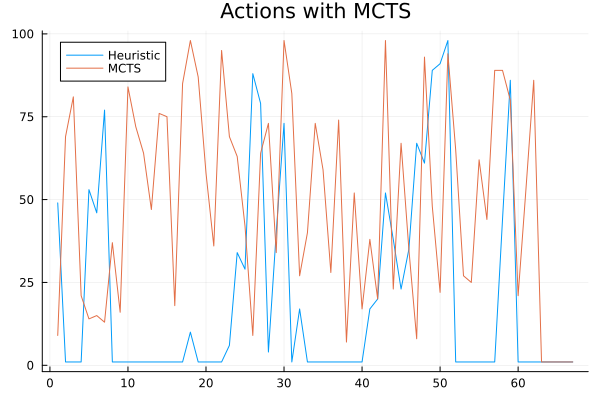

In [179]:
Plots.plot(index, action_list, label="Heuristic")
Plots.plot!(index, action_list_mcts, title="Actions with MCTS", label="MCTS")


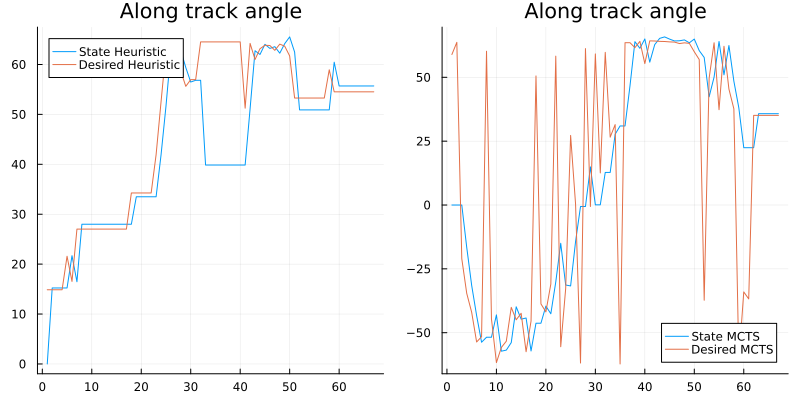

In [180]:
# plot(index, [y_angle_list, y_angle_list_mcts], label=["Random" "With MCTS"], title="Y angle")
random_along = Plots.plot(index, [y_angle_list, along_ang_des], label=["State Heuristic" "Desired Heuristic"])
mcts_along = Plots.plot(index, [y_angle_list_mcts, along_ang_des_mcts], label=["State MCTS" "Desired MCTS"])
Plots.plot(random_along, mcts_along,layout=(1, 2), title="Along track angle", size=(800, 400))
# plot(index, along_ang_des, label="Desired Random", title="Along Track angle")

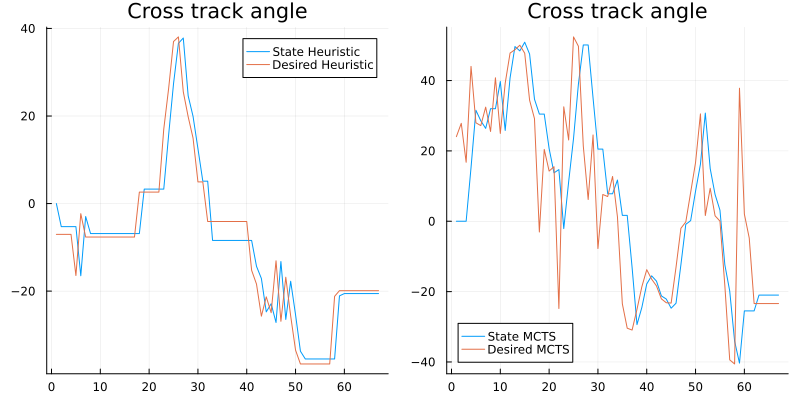

In [181]:
# plot(index, [y_angle_list, y_angle_list_mcts], label=["Random" "With MCTS"], title="Y angle")
random_along = Plots.plot(index, [x_angle_list, cross_ang_des], label=["State Heuristic" "Desired Heuristic"])
mcts_along = Plots.plot(index, [x_angle_list_mcts, cross_ang_des_mcts], label=["State MCTS" "Desired MCTS"])
Plots.plot(random_along, mcts_along,layout=(1, 2), title="Cross track angle", size=(800, 400))
# plot(index, along_ang_des, label="Desired Random", title="Along Track angle")

### Globe plots

In [160]:
koe = [state.koe for state in state_list]
dts = [state.dt for state in state_list]
state_ECEF = zeros(6, length(dts))
state_ECI = zeros(6, length(dts))
state_lambda = zeros(length(dts))
state_phi = zeros(length(dts))
for (i, koe) in enumerate(koe)
    rv = koe2cart(koe, mu_E)
    rv_ecef = ECI_to_ECEF(rv, dts[i])
    state_lambda[i] = atand(rv_ecef[2], rv_ecef[1])
    state_phi[i] = atand(rv_ecef[3], sqrt(rv_ecef[1]^2 + rv_ecef[2]^2))
end

layout = @layout [a b]
f = Figure(size = (1200, 800), layout=layout)
lon,lat,data = GeoDatasets.landseamask(;resolution='c',grid=5)
ax1 = Axis(f[1, 1], aspect=DataAspect(), title = "Heuristic")
GLMakie.scatter!(ax1, target_lambda, target_phi, overdraw = true, color = :red, markersize = 10*target_mean_reward)
GLMakie.scatter!(ax1, observed_target_lambda , observed_target_phi, overdraw = true, color = :blue, markersize = 10*observed_target_reward)
GLMakie.contour!(ax1, lon, lat, data, levels=[0.5], color=:black, linewidth=0.5)
lines!(ax1, state_lambda, state_phi, overdraw = true, color = :blue, linewidth = 2,)
GLMakie.ylims!(ax1, low = -90, high = 90)
GLMakie.xlims!(ax1, low = -180, high = 180)
# save(f, "globe.png")

mcts_koe = [state.koe for state in state_list_mcts]
mcts_dts = [state.dt for state in state_list_mcts]
state_ECEF = zeros(6, length(mcts_dts))
state_ECI = zeros(6, length(mcts_dts))
mcts_state_lambda = zeros(length(mcts_dts))
mcts_state_phi = zeros(length(mcts_dts))
for (i, koe) in enumerate(mcts_koe)
    rv = koe2cart(koe, mu_E)
    rv_ecef = ECI_to_ECEF(rv, mcts_dts[i])
    mcts_state_lambda[i] = atand(rv_ecef[2], rv_ecef[1])
    mcts_state_phi[i] = atand(rv_ecef[3], sqrt(rv_ecef[1]^2 + rv_ecef[2]^2))
end


lon,lat,data = GeoDatasets.landseamask(;resolution='c',grid=5)
ax2 = Axis(f[1, 2], aspect=DataAspect(), title = "MCTS")
GLMakie.scatter!(ax2, target_lambda, target_phi, overdraw = true, color = :red, markersize = 10*target_mean_reward)
GLMakie.scatter!(ax2, mcts_observed_target_lambda , mcts_observed_target_phi, overdraw = true, color = :blue, markersize = 10*mcts_observed_target_reward)
GLMakie.contour!(ax2, lon, lat, data, levels=[0.5], color=:black, linewidth=0.5)
lines!(ax2, mcts_state_lambda, mcts_state_phi, overdraw = true, color = :blue, linewidth = 2,)
GLMakie.ylims!(ax2, low = -90, high = 90)
GLMakie.xlims!(ax2, low = -180, high = 180)
display(f)
# save(f, "mcts_globe.png")



GLMakie.Screen(...)

### OLD PLots

In [ ]:
# plt = plot(x_list, y_list, label="Position", aspect_ratio=:equal, legend=:bottomleft, dpi=500)

# for i in 1:length(x_list)
#     if action_list[i] != 1
#         plot!([x_list[i], target_x_r[action_list[i] - 1]], [y_list[i], target_y_r[action_list[i] - 1]], label="", c="gray")
#     end
# end

# reward_round = round(reward_total, digits=2)
# text_to_display = "Reward: $reward_round"
# annotate!((-35, 30, text(text_to_display, 10, :left, :center, :black)))


# scatter!(target_x_r,target_y_r, mc="green", label="Unobserved targets", markersize = 10*target_reward_r)
# scatter!(observed_target_x_r,observed_target_y_r, mc="blue", label="Observed targets", markersize = 10*observed_target_reward_r)
# display(plt)

# savefig(plt, "random_targeting.png")


In [ ]:
# plt = plot(x_list_mcts, y_list_mcts, label="Position", aspect_ratio=:equal, legend=:bottomleft, dpi=500)

# for i in 1:length(x_list_mcts)
#     if action_list_mcts[i] != 1
#         plot!([x_list_mcts[i], target_x[action_list_mcts[i] - 1]], [y_list_mcts[i], target_y[action_list_mcts[i] - 1]], label="", c="gray")
#     end
# end

# reward_mcts_round = round(reward_total_mcts, digits=2)
# text_to_display = "Reward: $reward_mcts_round"
# annotate!((-35, 30, text(text_to_display, 10, :left, :center, :black)))

# scatter!(target_x,target_y, mc="green", label="Unobserved targets", markersize = 10*target_reward)
# scatter!(observed_target_x,observed_target_y, mc="blue", label="Observed targets", markersize = 10*observed_target_reward)

# display(plt)
# savefig(plt, "mcts_targeting.png")